# REMEMBER to start the spark cluster with the little star icon before executing the notebook


# Hands-on Day 1

- course [slides](https://github.com/leggerf/MLCourse-1920/blob/master/Slides/Day1/ML-day1.pdf)

# You'll learn

- familiarize with jupyter notebooks, numpy and pandas

## Input data
- efficient data format: convert CSV to Parquet
- create input vector with features for MLLib. Format of the input depends on chosen ML library

## Visualization
- explore dataset, plot features
- correlation matrix


# Dataset description

The dataset used in this example is described [here](https://archive.ics.uci.edu/ml/datasets/HIGGS). It is a binary classification problem where the goal is to train a classifier able to distinguish between a signal process, the production of new theoretical Higgs bosons, and a background process with identical decay products but distinct kinematic features.

Each row of this dataset contains 28 features plus the label:

- 21 low-level features which represent the basic measure made by the particle detector
 -        Momentum of the observed paricles
 -        Missing transverse momentum
 -        Jets and b-tagging information
- 7 high-level features computed from the low-level features that encode the knowledge of the different intermediate states of the two processes (reconstructed invariant masses)

## Prepare the execution environment

Your code will run on a single dedicated server with 24 cores (hyperthreading enabled) and 192 GB of RAM. 
All the services needed for this tutorial are deployed as Kubernetes applications on this server. These include:
* JupytherHub
* Jupyter single-user servers
* the HDFS file-system
* Spark Clusters on demand 

In [1]:
!pip install pandas
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

## Read in local csv files


In [3]:
inputFile = 'Higgs100k.csv'

#into panda DF
%time dataset = pd.read_csv(inputFile)

CPU times: user 768 ms, sys: 208 ms, total: 976 ms
Wall time: 976 ms


In [4]:
#then into spark dataframe...remember to start spark with the little icon

%time df = spark.createDataFrame(dataset)

CPU times: user 15.5 s, sys: 360 ms, total: 15.9 s
Wall time: 26.2 s


In [5]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(df.rdd.getNumPartitions()))
print("Partitioner: {}".format(df.rdd.partitioner))

Number of partitions: 2
Partitioner: None


# Now let's have a look at the input data

In [6]:
%time total_events = df.count()

print('There are '+str(total_events)+' events')

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 9.28 s
There are 99999 events


In [7]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

# Exercise 3

- Create a function that makes a plot of any of the above variable for signal versus background (using the label variable to discriminate)
  - see an example of the plot in the hands-on [slides](https://github.com/leggerf/MLCourse-1920/blob/master/Slides/Day1/ML-handson-day1.pdf)
  - the function should take as input the dataframe *df* and the variable name. For example `plotSignalvsBg(df, 'm_bb')`
  - to develop the code, use the 100k dataset, so that debugging goes quicker
- try to plot a few input variables and try to understand which ones are more promising to distinguish signal from background  

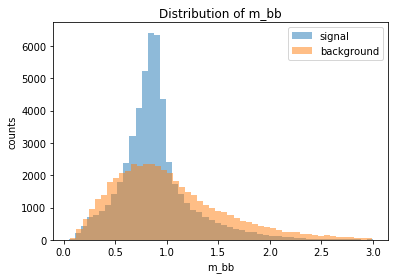

In [8]:
#plot invariant mass distribution 
plotSignalvsBg(df, 'm_bb')

# Exercise 4 - Bonus

#### Create the input feature vector

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe df a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer

In [9]:
#create input vector for ML (features)
feature = df.columns
feature.remove('label')

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
df = assembler.transform(df)

#take a look at how there is now a features column
display(df)
df.select('features').take(1)

#note also that features are already standardised between -1 and 1, so rescaling won't be needed

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([0.8693, -0.6351, 0.2257, 0.3275, -0.69, 0.7542, -0.2486, -1.0921, 0.0, 1.375, -0.6537, 0.9303, 1.1074, 1.1389, -1.5782, -1.047, 0.0, 0.6579, -0.0105, -0.0458, 3.102, 1.3538, 0.9796, 0.9781, 0.92, 0.7217, 0.9888, 0.8767]))]

Print (or draw) the correlation matrix (a table showing correlation coefficients between variables)

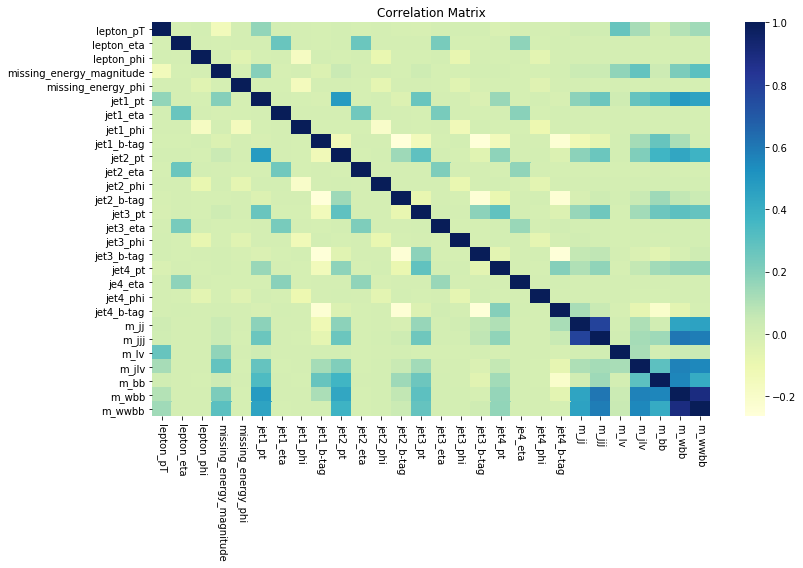

In [10]:
plotCorrelation(df, feature)

In [11]:
#when you're done, stop spark, this will release the resources you're using
#spark.stop()